# Blob Detection Pipeline

This tutorial introduces DataJoint through a real image analysis pipeline that detects bright blobs in astronomical and biological images. By the end, you'll understand:

- **Schemas** — Namespaces that group related tables
- **Table types** — Manual, Lookup, and Computed tables
- **Dependencies** — How tables relate through foreign keys
- **Computation** — Automatic population of derived data
- **Master-Part** — Atomic insertion of hierarchical results

## The Problem

We have images and want to detect bright spots (blobs) in them. Different detection parameters work better for different images, so we need to:

1. Store our images
2. Define parameter sets to try
3. Run detection for each image × parameter combination
4. Store and visualize results
5. Select the best parameters for each image

This is a **computational workflow** — a series of steps where each step depends on previous results. DataJoint makes these workflows reproducible and manageable.

## Setup

First, let's import our tools and create a schema (database namespace) for this project.

In [1]:
import datajoint as dj
import matplotlib.pyplot as plt
from skimage import data
from skimage.feature import blob_doh
from skimage.color import rgb2gray

# Create a schema - this is our database namespace
schema = dj.Schema('tutorial_blobs')

[2026-01-17 00:49:33,912][INFO]: DataJoint 2.0.0a22 connected to root@127.0.0.1:3306


## Manual Tables: Storing Raw Data

A **Manual table** stores data that users enter directly — it's the starting point of your pipeline. Here we define an `Image` table to store our sample images.

The `definition` string specifies:
- **Primary key** (above `---`): attributes that uniquely identify each row
- **Secondary attributes** (below `---`): additional data for each row

In [2]:
@schema
class Image(dj.Manual):
    definition = """
    # Images for blob detection
    image_id : int16
    ---
    image_name : varchar(100)
    image : <blob>              # serialized numpy array
    """

Now let's insert two sample images from scikit-image:

In [3]:
# Insert sample images
Image.insert([
    {'image_id': 1, 'image_name': 'Hubble Deep Field', 
     'image': rgb2gray(data.hubble_deep_field())},
    {'image_id': 2, 'image_name': 'Human Mitosis', 
     'image': data.human_mitosis() / 255.0},
], skip_duplicates=True)

Image()

image_id,image_name,image serialized numpy array
1,Hubble Deep Field,<blob>
2,Human Mitosis,<blob>


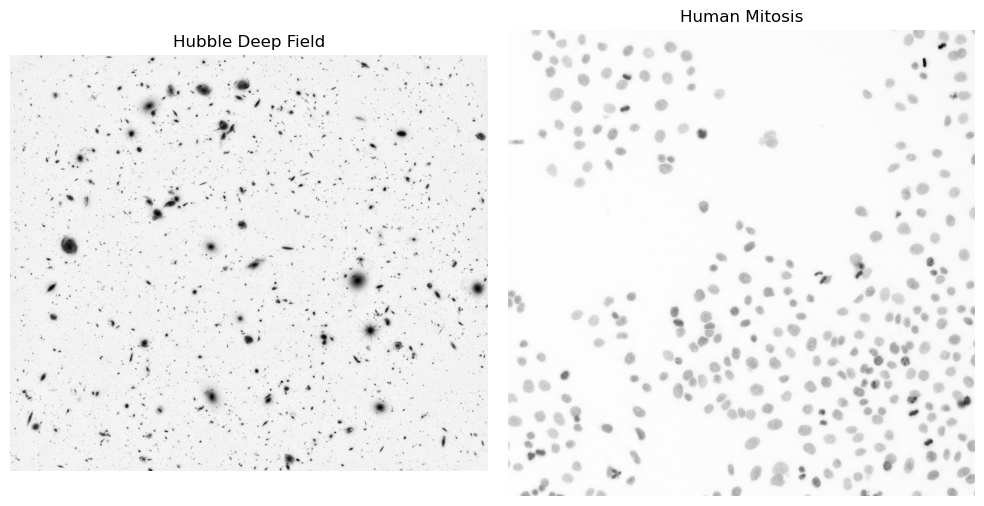

In [4]:
# Visualize the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, row in zip(axes, Image()):
    ax.imshow(row['image'], cmap='gray_r')
    ax.set_title(row['image_name'])
    ax.axis('off')
plt.tight_layout()

## Lookup Tables: Parameter Sets

A **Lookup table** stores reference data that doesn't change often — things like experimental protocols, parameter configurations, or categorical options.

For blob detection, we'll try different parameter combinations to find what works best for each image type.

In [5]:
@schema
class DetectionParams(dj.Lookup):
    definition = """
    # Blob detection parameter sets
    params_id : int16
    ---
    min_sigma : float32         # minimum blob size
    max_sigma : float32         # maximum blob size  
    threshold : float32         # detection sensitivity
    """
    
    # Pre-populate with parameter sets to try
    contents = [
        {'params_id': 1, 'min_sigma': 2.0, 'max_sigma': 6.0, 'threshold': 0.001},
        {'params_id': 2, 'min_sigma': 3.0, 'max_sigma': 8.0, 'threshold': 0.002},
        {'params_id': 3, 'min_sigma': 4.0, 'max_sigma': 20.0, 'threshold': 0.01},
    ]

DetectionParams()

params_id,min_sigma minimum blob size,max_sigma maximum blob size,threshold detection sensitivity
1,2.0,6.0,0.001
2,3.0,8.0,0.002
3,4.0,20.0,0.01


## Computed Tables: Automatic Processing

A **Computed table** automatically derives data from other tables. You define:

1. **Dependencies** (using `->`) — which tables provide input
2. **`make()` method** — how to compute results for one input combination

DataJoint then handles:
- Determining what needs to be computed
- Running computations (optionally in parallel)
- Tracking what's done vs. pending

### Master-Part Structure

Our detection produces multiple blobs per image. We use a **master-part** structure:
- **Master** (`Detection`): One row per job, stores summary (blob count)
- **Part** (`Detection.Blob`): One row per blob, stores details (x, y, radius)

Both are inserted atomically — if anything fails, the whole transaction rolls back.

In [6]:
@schema
class Detection(dj.Computed):
    definition = """
    # Blob detection results
    -> Image                    # depends on Image
    -> DetectionParams          # depends on DetectionParams
    ---
    num_blobs : int32          # number of blobs detected
    """
    
    class Blob(dj.Part):
        definition = """
        # Individual detected blobs
        -> master
        blob_idx : int32
        ---
        x : float32             # x coordinate
        y : float32             # y coordinate  
        radius : float32        # blob radius
        """
    
    def make(self, key):
        # Fetch the image and parameters
        img = (Image & key).fetch1('image')
        params = (DetectionParams & key).fetch1()
        
        # Run blob detection
        blobs = blob_doh(
            img,
            min_sigma=params['min_sigma'],
            max_sigma=params['max_sigma'],
            threshold=params['threshold']
        )
        
        # Insert master row
        self.insert1({**key, 'num_blobs': len(blobs)})
        
        # Insert part rows (all blobs for this detection)
        self.Blob.insert([
            {**key, 'blob_idx': i, 'x': x, 'y': y, 'radius': r}
            for i, (x, y, r) in enumerate(blobs)
        ])

## Viewing the Schema

DataJoint can visualize the relationships between tables:

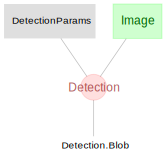

In [7]:
dj.Diagram(schema)

The diagram shows:
- **Green** = Manual tables (user-entered data)
- **Gray** = Lookup tables (reference data)
- **Red** = Computed tables (derived data)
- **Edges** = Dependencies (foreign keys), always flow top-to-bottom

## Running the Pipeline

Call `populate()` to run all pending computations. DataJoint automatically determines what needs to be computed: every combination of `Image` × `DetectionParams` that doesn't already have a `Detection` result.

In [8]:
# Run all pending computations
Detection.populate(display_progress=True)

Detection:   0%|          | 0/6 [00:00<?, ?it/s]

Detection:  17%|█▋        | 1/6 [00:00<00:01,  4.25it/s]

Detection:  33%|███▎      | 2/6 [00:00<00:02,  1.98it/s]

Detection:  50%|█████     | 3/6 [00:01<00:01,  2.79it/s]

Detection:  67%|██████▋   | 4/6 [00:01<00:00,  2.62it/s]

Detection:  83%|████████▎ | 5/6 [00:01<00:00,  3.32it/s]

Detection: 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

Detection: 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

{'success_count': 6, 'error_list': []}

In [9]:
# View results summary
Detection()

image_id,params_id,num_blobs number of blobs detected
1,1,1921
1,2,971
1,3,229
2,1,364
2,2,232
2,3,11


We computed 6 results: 2 images × 3 parameter sets. Each shows how many blobs were detected.

## Visualizing Results

Let's see how different parameters affect detection:

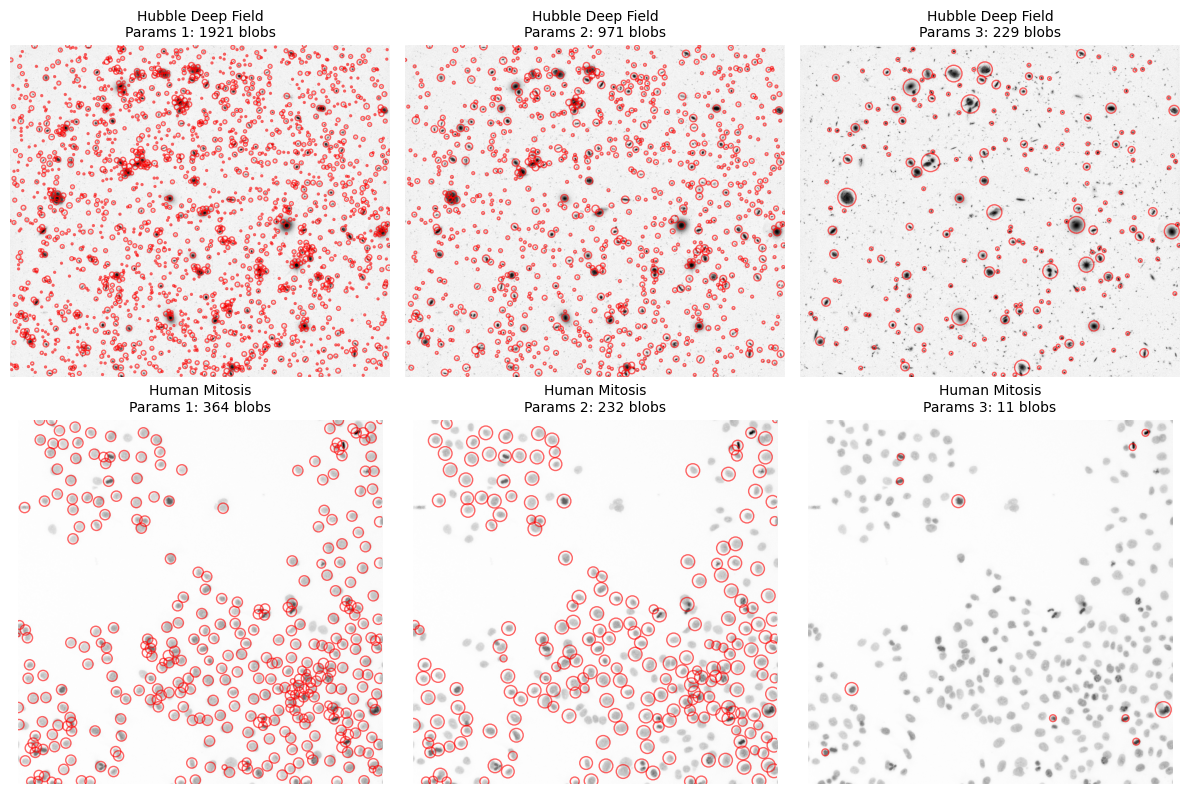

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, key in zip(axes.ravel(),
                   Detection.keys(order_by='image_id, params_id')):
    # Get image and detection info in one fetch
    name, img, num_blobs = (Detection * Image & key).fetch1(
        'image_name', 'image', 'num_blobs')
    
    ax.imshow(img, cmap='gray_r')
    
    # Get all blob coordinates in one query
    x, y, r = (Detection.Blob & key).to_arrays('x', 'y', 'radius')
    for xi, yi, ri in zip(x, y, r):
        circle = plt.Circle((yi, xi), ri * 1.2,
                            color='red', fill=False, alpha=0.6)
        ax.add_patch(circle)
    
    ax.set_title(f"{name}\nParams {key['params_id']}: {num_blobs} blobs",
                 fontsize=10)
    ax.axis('off')

plt.tight_layout()

## Querying Results

DataJoint's query language makes it easy to explore results:

In [11]:
# Find detections with fewer than 300 blobs
Detection & 'num_blobs < 300'

image_id,params_id,num_blobs number of blobs detected
1,3,229
2,2,232
2,3,11


In [12]:
# Join to see image names with blob counts
(Image * Detection).proj('image_name', 'num_blobs')

image_id,params_id,num_blobs number of blobs detected,image_name
1,1,1921,Hubble Deep Field
1,2,971,Hubble Deep Field
1,3,229,Hubble Deep Field
2,1,364,Human Mitosis
2,2,232,Human Mitosis
2,3,11,Human Mitosis


## Storing Selections

After reviewing the results, we can record which parameter set works best for each image. This is another Manual table that references our computed results:

In [13]:
@schema
class SelectedDetection(dj.Manual):
    definition = """
    # Best detection for each image
    -> Image
    ---
    -> Detection
    """

# Select params 3 for Hubble (fewer, larger blobs)
# Select params 1 for Mitosis (many small spots)
SelectedDetection.insert([
    {'image_id': 1, 'params_id': 3},
    {'image_id': 2, 'params_id': 1},
], skip_duplicates=True)

SelectedDetection()

image_id,params_id
1,3
2,1


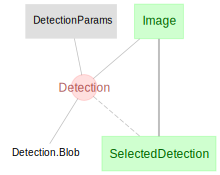

In [14]:
# View the final schema with selections
dj.Diagram(schema)

## Key Concepts Recap

| Concept | What It Does | Example |
|---------|--------------|--------|
| **Schema** | Groups related tables | `schema = dj.Schema('tutorial_blobs')` |
| **Manual Table** | Stores user-entered data | `Image`, `SelectedDetection` |
| **Lookup Table** | Stores reference/config data | `DetectionParams` |
| **Computed Table** | Derives data automatically | `Detection` |
| **Part Table** | Stores detailed results with master | `Detection.Blob` |
| **Foreign Key** (`->`) | Creates dependency | `-> Image` |
| **`populate()`** | Runs pending computations | `Detection.populate()` |
| **Restriction** (`&`) | Filters rows | `Detection & 'num_blobs < 300'` |
| **Join** (`*`) | Combines tables | `Image * Detection` |

## Next Steps

- [Schema Design](../../basics/02-schema-design) — Learn table types and relationships in depth
- [Queries](../../basics/04-queries) — Master DataJoint's query operators
- [Computation](../../basics/05-computation) — Build complex computational workflows

In [15]:
# Cleanup: drop the schema for re-running the tutorial
schema.drop(prompt=False)